## Modules à importer

In [6]:
import math
import scipy
import pickle
import sncosmo
import numpy as np
import pandas as pd
import iminuit as im
import ipywidgets as ipw
from importlib import reload
from scipy.stats import poisson
import scipy.integrate as integrate
from variaIa.variaIa import baserate
from scipy.interpolate import interp1d
from variaIa.variaIa import stretchevol
from astropy.cosmology import Planck15
import matplotlib.pyplot as plt
import random

ModuleNotFoundError: No module named 'variaIa'

## Définitions et sélection de l'échantillon à utiliser

In [7]:
d = pd.read_csv('../Data/data_cheat.csv', sep=' ', index_col='CID')
d_snf = pd.read_csv('../Data/lssfr_paper_full_sntable.csv', sep=',')

surveys = ['SNF', 'SDSS', 'PS1', 'SNLS', 'HST']

su = ipw.Dropdown(options=surveys,
                  description='Survey:',
                  value='PS1')

surv = {'SNF':  d_snf,
        'SDSS': d[d['IDSURVEY'] == 1],
        'PS1':  d[d['IDSURVEY'] == 15],
        'SNLS': d[d['IDSURVEY'] == 4],
        'HST':  d[d['IDSURVEY'].isin([101, 100, 106])]}

# .loc[d_snf['name'].str.contains('SNF|LSQ|PTF',na=False,regex=True)]

colors = {'SNF': 'orange',
          'SDSS': 'lime',
          'PS1': 'blue',
          'SNLS': 'red',
          'HST': 'purple'}

def set_data(su):
    global dataz, datax
    if su == 'SNF':
        dataz = np.sort(surv[su]['host.zcmb'].values)
    else:
        dataz = np.sort(surv[su].zCMB.values)
    
int_data = ipw.interactive(set_data, su=su)
display(int_data)

interactive(children=(Dropdown(description='Survey:', index=2, options=('SNF', 'SDSS', 'PS1', 'SNLS', 'HST'), …

# Détermination des $z_{\text{max}}$ _via_ SNcosmo

In [15]:
model = sncosmo.Model(source="salt2")
model.set(z=.1, t0=55000., x1=1., c=0.1)
model.cosmo = Planck15
model.set_source_peakabsmag(-19.3, 'bessellb', 'ab', 1.0, Planck15)

In [16]:
model.bandmag('bessellb', 'ab', [54990., 55000., 55020.]) - model.cosmo.distmod(model['z']).value

array([-27.27607164, -27.79248768, -26.30075126])

In [14]:
Planck15.distmod(model["z"]).value

38.38500782579381

In [27]:
model = sncosmo.Model("salt2")
model.set(z=0.00000001, t0=55000, c=0., x1=0)
model.set_source_peakabsmag(-19.3, "bessellb", "ab", cosmo=Planck15)
model.update({"c":0.2})
model.bandmag('bessellb', 'ab', model["t0"]-5) - Planck15.distmod(model["z"]).value

-19.145616659888773

In [93]:
M_list = []
model = sncosmo.Model("salt2")
model.set(z=0.00000001, t0=55000, c=0., x1=0)
model.set_source_peakabsmag(-19.3, "bessellb", "ab", cosmo=Planck15)

data = dict()

for i in range(len(t)):
    data[i] = {'c': b*np.sin(t)[i],
                  'x1': a*np.cos(t)[i]}
    model.update(data[i])
    data[i]['M'] = model.bandmag('bessellb', 'ab', model["t0"]-5) - Planck15.distmod(model["z"]).value

In [94]:
df = pd.DataFrame(data).T
df['M_eff'] = df['M']-0.141*df['x1']+3.15*df['c']

(-0.4, 0.4)

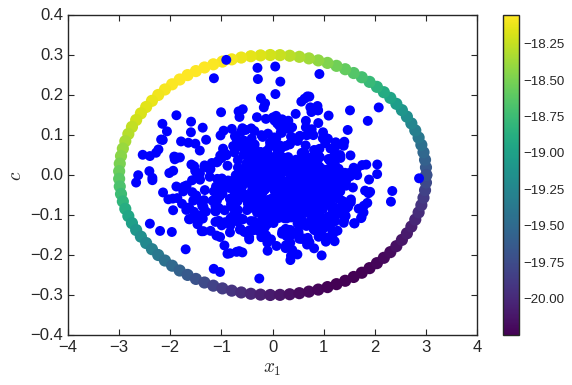

In [108]:
a=3.     #radius on the x-axis
b=.3    #radius on the y-axis

t = np.linspace(0, 2*pi, 100)

fig = plt.figure(figsize=[8, 5])
ax = fig.add_axes([0.1, 0.12, 0.8, 0.8])

ts = ax.scatter(df['x1'],
                df['c'],
                marker='o',
                cmap='viridis',
                c=df['M_eff'], edgecolors="None",
                s=120,
                zorder=2)

fig.colorbar(ts)

for survey in surveys[1:-1]:
    ax.scatter(surv[survey].x1,
               surv[survey].c,
               marker='o',
               edgecolors="None",
               s=80,
               zorder=2)

ax.tick_params(direction='in',
               length=5, width=1,
               labelsize=15,
               top=True, right=True)

ax.set_xlabel(r'$x_1$', fontsize='x-large')
ax.set_ylabel(r'$c$', fontsize='x-large')

ax.set_xlim(-4, 4)
ax.set_ylim(-.4, .4)

# plt.legend(ncol=1, loc='upper left', fontsize='x-large')

In [96]:
df.sort_values('M_eff', ascending=False).iloc[0]['M_eff']

-18.045177354310507

In [112]:
21.8-df.sort_values('M_eff', ascending=False).iloc[0]['M_eff']

39.84517735431051

In [115]:
Planck15.distmod(0.18)

<Quantity 39.77044192 mag>

In [116]:
with open('../Data/zmax_spec_result', 'rb') as f:
    z_lins, meds, stds, z_max, itsc = pickle.load(f)

In [117]:
z_max

{'SDSS': [0.1728, 0.2039, 0.2301],
 'PS1': [0.1821, 0.2732, 0.3568],
 'SNLS': [0.5937, 0.6162, 0.6565]}

In [118]:
from scipy import optimize

In [135]:
def find_zmax(mag_lim, magabs_lim=-18.):
    return(find_z(mag_lim - magabs_lim))

def find_z(distmod, cosmo=None):
    if cosmo is None:
        from astropy.cosmology import Planck15
        cosmo = Planck15
    return(optimize.fmin(lambda z: np.abs(cosmo.distmod(z).value - distmod), 0.1, disp=0))

In [137]:
find_zmax(24.5)

array([0.53460938])

## Définition de $m_{\mathrm{obs}}$ depuis la RG

In [4]:
alpha = 0.141
beta = 3.101
O_m = 0.315
O_L = 0.692
O_R = 1 - O_m - O_L
c = 9.715611890751e-9 #in pc.s⁻¹
H0 = Planck15.H(0).value*3.2407792899604e-20 #in s⁻¹

def integrand(zp):
    return((O_R*(1+zp)**4 + O_m*(1+zp)**3 + O_L)**(-1/2))

def d_L(z):
    return((1+z)*c/H0*integrate.quad(integrand, 0, z)[0])

def m_obs(M_abs, x1, c, z):
    return(5*np.log10(d_L(z)/10) + M_abs - alpha*x1 + beta*c)

## Calcul de $m_{\mathrm{obs}}$ sur un pavage de $(x_1, c)$

In [5]:
c_lin = np.linspace(-.4, .4, 1000)
x1_lin = 10*c_lin
m_list = [[] for i in range(len(c_lin))]
M_abs = -19.3
z_obs = 0.50

for i in range(len(c_lin)):
    m_list[i] = np.asarray([m_obs(M_abs, x1_lin[k], c_lin[i], z_obs) for k in range(len(x1_lin))])

m_list = np.asarray(m_list)

## Détermination des $(x_1, c)$ observables (i.e. dont $m_{\mathrm{obs}}$ < $m_{\mathrm{max}}$)

In [6]:
m_max = 23.1
x1_max = []

for i in range(len(x1_lin)):
    loc = np.where(m_list[i] < m_max)
    if np.size(loc) > 0:
        x1_max.append(x1_lin[np.min(loc)])

x1_max = np.asarray(x1_max)

c_max = c_lin[:len(x1_max)]

(-0.4, 0.4)

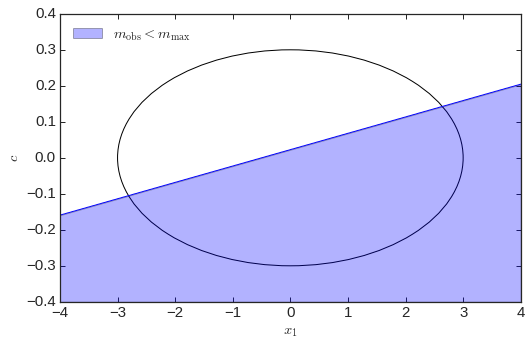

In [7]:
from matplotlib.patches import Ellipse

fig = plt.figure(figsize=[8, 5])
ax = fig.add_axes([0.1, 0.12, 0.8, 0.8])

ax.add_patch(Ellipse((0, 0),
             width=6,
             height=.6,
             ec="black",
             fc="1"))

ax.plot(x1_max,
        c_max, 
        color="blue")

ax.fill_between(x1_max,
                c_max,
                [-.4 for i in range(len(c_max))],
                alpha=.3, zorder=2,
                label=r'$m_{\mathrm{obs}} < m_{\mathrm{max}}$')

ax.tick_params(direction='in',
               length=5, width=1,
               labelsize=15,
               top=True, right=True)

ax.set_xlabel(r'$x_1$', fontsize='x-large')
ax.set_ylabel(r'$c$', fontsize='x-large')

plt.legend(ncol=1, loc='upper left', fontsize='x-large')

ax.set_xlim(-4, 4)
ax.set_ylim(-.4, .4)

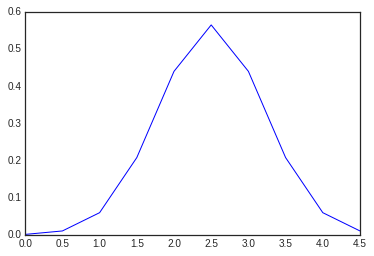

In [19]:
from scipy.stats import multivariate_normal
x = np.linspace(0, 5, 10, endpoint=False)
y = multivariate_normal.pdf(x, mean=2.5, cov=0.5)
plt.plot(x, y)

(-0.4, 0.4)

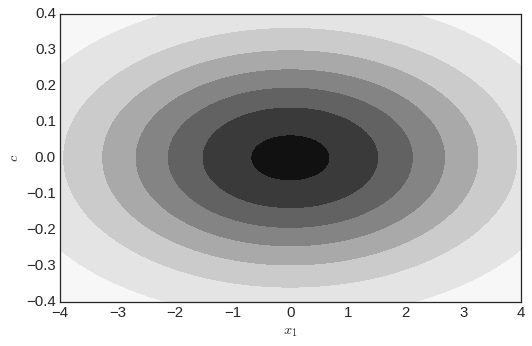

In [140]:
x, y = np.mgrid[-4:4:.001, -.4:.4:.001]
pos = np.empty(x.shape + (2,))
pos[:, :, 0] = x; pos[:, :, 1] = y
rv = multivariate_normal([0, 0], [[6.0, 0], [0, 0.05]])

fig = plt.figure(figsize=[8, 5])
ax2 = fig.add_axes([0.1, 0.12, 0.8, 0.8])

ax2.contourf(x, y, rv.pdf(pos))

ax2.tick_params(direction='in',
                length=5, width=1,
                labelsize=15,
                top=True, right=True)

ax2.set_xlabel(r'$x_1$', fontsize='x-large')
ax2.set_ylabel(r'$c$', fontsize='x-large')

ax2.set_xlim(-4, 4)
ax2.set_ylim(-.4, .4)

TypeError: Input z must be a 2D array.

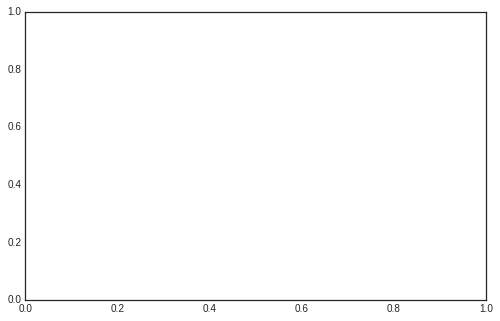

In [73]:
fig = plt.figure(figsize=[8, 5])
ax3 = fig.add_axes([0.1, 0.12, 0.8, 0.8])

x = np.linspace(-4, 4, 1000)
y = np.linspace(-.4, .4, 1000)

ax3.contourf(x, y, (x/(3.*np.sqrt(9.210)))**2 + ((y)/(1*np.sqrt(9.210))))

ax3.tick_params(direction='in',
                length=5, width=1,
                labelsize=15,
                top=True, right=True)

ax3.set_xlabel(r'$x_1$', fontsize='x-large')
ax3.set_ylabel(r'$c$', fontsize='x-large')

#ax3.set_xlim(-4, 4)
#ax3.set_ylim(-.4, .4)

In [4]:
from pylab import *
import numpy as np
from shapely.geometry.polygon import LinearRing
from shapely.geometry import LineString
def ellipse_polyline(ellipses, n=100):
    t = np.linspace(0, 2*np.pi, n, endpoint=False)
    st = np.sin(t)
    ct = np.cos(t)
    result = []
    for x0, y0, a, b, angle in ellipses:
        angle = np.deg2rad(angle)
        sa = np.sin(angle)
        ca = np.cos(angle)
        p = np.empty((n, 2))
        p[:, 0] = x0 + a * ca * ct - b * sa * st
        p[:, 1] = y0 + a * sa * ct + b * ca * st
        result.append(p)
    return result

def intersections(a, line):
    ea = LinearRing(a)
    mp = ea.intersection(line)
    if mp.is_empty:
        print('Geometries do not intersect')
        return [], []
    elif mp.geom_type == 'Point':
        return [mp.x], [mp.y]
    elif mp.geom_type == 'MultiPoint':
        return [p.x for p in mp], [p.y for p in mp]
    else:
        raise ValueError('something unexpected: ' + mp.geom_type)

ellipses = [(1, 1, 2, 1, 45)]
a = ellipse_polyline(ellipses)
line=LineString([[0,0],[4,4]])
x, y = intersections(a, line)
figure()
plot(x, y, "o")
plot(a[:,0], a[:,1])
plot(b[:,0], b[:,1])
show()

ValueError: A LinearRing must have at least 3 coordinate tuples